# Акустические модели

Акустическая модель - это часть системы автоматического распознавания речи, которая используется для преобразования аудиосигнала речи в последовательность фонем или других единиц речевого звука. Акустическая модель обучается на большом наборе речевых данных, чтобы определить, какие звуки соответствуют конкретным акустическим признакам в аудиосигнале. Эта модель может использоваться вместе с другими компонентами, такими как языковая модель и модель декодирования, чтобы достичь более точного распознавания речи.

В данной работе мы сконцентрируемся на обучении нейросетевых акустических моделей с помощью библиотек torch и torchaudio. Для экспериментов будем использовать базу [TIMIT](https://catalog.ldc.upenn.edu/LDC93s1)

In [1]:
import numpy as np
import time
import torch
import os
from typing import List, Dict, Union, Set, Any
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict, Counter
from pathlib import Path
import pandas as pd
import soundfile as sf
import torchaudio
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display


# Загрузка датасета TIMIT

Официальная страница датасета TIMIT 

Для простоты загрузки данных удобнее всего пользоваться копией датасета, выложенной на kaggle 

https://www.kaggle.com/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech


In [2]:
# !pip install kaggle

In [3]:
# https://github.com/Kaggle/kaggle-api - Docs kaggle 
# Simplest way: go to https://www.kaggle.com/settings , "Create new token" and move it into "~/.kaggle"

# !kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech

In [4]:
# !unzip -o -q darpa-timit-acousticphonetic-continuous-speech.zip -d timit/

# 1. Подготовка данных для обучения

TIMIT является одной из самых широко используемых баз данных для изучения систем автоматического распознавания речи. База данных TIMIT содержит произнесения предложений различными дикторами. Каждое произнесение сопровождается его словной и фонетической разметкой.

Для обучения акустической модели нам в первую очередь интересна фонетическая разметка произнесений. Такая разметка сопоставляет фонемы, которые были произнесены диктором, с временными интервалами в записи. Такая разметка позволит нам обучить пофреймовый классификатор, который будет предсказывать сказанную фонему.

## 1.a. Загрузка базы с диска

In [5]:
class TimitDataset(Dataset):
    """Загрузка TIMIT данных с диска"""
    def __init__(self, data_path):
        self.data_path = data_path
        self.uri2wav = {}
        self.uri2text = {}
        self.uri2word_ali = {}
        self.uri2phone_ali = {}
        for d, _, fs in os.walk(data_path):
            for f in fs:
                full_path = f'{d}/{f}'
                if f.endswith('.WAV'):
                    # skip it. Use .wav instead
                    pass
                elif f.endswith('.wav'):
                    stem = Path(f[:-4]).stem # .WAV.wav
                    self.uri2wav[f'{d}/{stem}'] = full_path
                elif f.endswith('.TXT'):
                    stem = Path(f).stem
                    self.uri2text[f'{d}/{stem}'] = full_path
                elif f.endswith('.WRD'):
                    stem = Path(f).stem
                    self.uri2word_ali[f'{d}/{stem}'] = full_path
                elif f.endswith('.PHN'):
                    stem = Path(f).stem
                    self.uri2phone_ali[f'{d}/{stem}'] = full_path
                else:
                    warnings.warn(f"Unknown file type {full_path} . Skip it.")
        
        self.uris = list(sorted(set(self.uri2wav.keys()) \
                                & set(self.uri2text.keys()) \
                                & set(self.uri2word_ali.keys()) \
                                &  set(self.uri2phone_ali.keys())
                               ))
        print(f"Found {len(self.uris)} utterances in {self.data_path}. ", 
              f"{len(self.uri2wav)} wavs, ", 
              f"{len(self.uri2text)} texts, ",
              f"{len(self.uri2word_ali)} word alinments, ",
             f"{len(self.uri2phone_ali)} phone alignments")
    
    def get_uri(self, index_or_uri: Union[str, int]):
        if isinstance(index_or_uri, str):
            uri = index_or_uri
        else:
            uri = self.uris[index_or_uri]
        return uri
    
    
    def get_audio(self, index_or_uri: Union[str, int]):
        uri = self.get_uri(index_or_uri)
        wav_path = self.uri2wav[uri]
        wav_channels, sr = torchaudio.load(wav_path)
        return wav_channels[0], sr 
        
    def get_text(self, index_or_uri: Union[str, int]):
        """ Return (start_sample, stop_sample, text)"""
        uri = self.get_uri(index_or_uri)
        txt_path = self.uri2text[uri]
        with open(txt_path) as f:
            start, stop, text = f.read().strip().split(maxsplit=2)
            start, stop = int(start), int(stop)
            assert start == 0, f"{txt_path}"
        return start, stop, text
    
    def get_word_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, word), ...]"""
        uri = self.get_uri(index_or_uri)
        wrd_path = self.uri2word_ali[uri]
        with open(wrd_path) as f:
            words = [(int(start), int(stop), word) for start, stop, word in map(str.split, f.readlines())]
        return words
    
    def get_phone_ali(self, index_or_uri):
        """ Return [(start_sample, stop_sample, phone), ...]"""
        uri = self.get_uri(index_or_uri)
        ph_path = self.uri2phone_ali[uri]
        with open(ph_path) as f:
            phonemes = [(int(start), int(stop), ph) for start, stop, ph in map(str.split, f.readlines())]
        return phonemes
    
    def __getitem__(self, index):
        return {"uri": self.get_uri(index),
                "audio": self.get_audio(index),
                "text": self.get_text(index),
                "word_ali": self.get_word_ali(index),
                "phone_ali": self.get_phone_ali(index)}       

    def __len__(self):
        # TODO
        # верните количество элементов в выборке 
        return len(self.uris)

    def total_audio_samples(self) -> int:
        #TODO
        total = 0
        for i in range(len(self.uri2wav)):
            num_samples = self.get_audio(i)[0].shape[0]
            total+=num_samples
        return total

    def total_num_words(self) -> int:
        #TODO
        total = 0
        for i in range(len(self.uri2word_ali)):
            num_words = len(self.get_word_ali(i))
            total+=num_words
        return total
    
    def total_num_phones(self) -> int:
        #TODO
        total = 0
        for i in range(len(self.uri2phone_ali)):
            num_phones = len(self.get_phone_ali(i))
            total+=num_phones
        return total
    
    def get_vocab(self) -> Set[str]:
        #TODO
        vocab = set()
        for i in range(len(self.uri2word_ali)):
            words = self.get_word_ali(i)
            for word in words:
                vocab.add(word[2])
        return vocab

    def get_phones(self) -> Set[str]:
        #TODO
        vocab = set()
        for i in range(len(self.uri2phone_ali)):
            phones = self.get_phone_ali(i)
            for phone in phones:
                vocab.add(phone[2])
        return vocab

    def phones_prior(self) -> Dict[str, float]:
        #TODO
        mapping = {}
        num_phones = 0
        for i in range(len(self.uri2phone_ali)):
            phones = self.get_phone_ali(i)
            num_phones+=len(phones)
            for phone in phones:
                if mapping.get(phone[2])!=None:
                    mapping[phone[2]] += 1
                else:
                    mapping[phone[2]] = 1
        for key in mapping.keys():
            mapping[key] = mapping[key]/num_phones
        return mapping
        

In [6]:
def test_timit_dataset_stats():
    test_ds = TimitDataset('timit/data/TEST/')

    print("Len")
    assert len(test_ds) == 1680, f"{len(test_ds)}"

    print("Audio")
    audio_len = test_ds.total_audio_samples()
    assert audio_len == 82986452, f"{audio_len}"

    print("Words")
    words_len = test_ds.total_num_words()
    assert words_len == 14553, f"{words_len}"

    print("Phones")
    phones_len = test_ds.total_num_phones()
    assert phones_len == 64145, f"{phones_len}"

    print("Vocab")
    vocab = test_ds.get_vocab()
    assert len(set(vocab)) == 2378, f"{len(set(vocab))}"

    print("Phones vocab")
    phones = test_ds.get_phones()
    assert len(set(phones)) == 61, f"{len(set(phones))}"
    
    print("Phones prior")
    priors = test_ds.phones_prior()
    assert np.isclose(sum(priors.values()), 1.0), f"sum(priors.values())"
    pmin, pmax = min(priors.keys(), key=priors.get), max(priors.keys(), key=priors.get)
    assert pmin == 'eng', pmin
    assert pmax == 'h#', pmax
    print("Test 1.a passed")
test_timit_dataset_stats()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Len
Audio


Words
Phones
Vocab
Phones vocab
Phones prior
Test 1.a passed


In [7]:
test_ds = TimitDataset('timit/data/TEST/')
item = test_ds[5]
print(item)
print(item['text'][2])
display.display(display.Audio(item['audio'][0].numpy(), rate=item['audio'][1]))
print('---words---')
for start, stop, word in item['word_ali']:
    print(word)
    display.display(display.Audio(item['audio'][0][start:stop].numpy(), rate=item['audio'][1]))
    break

Found 1680 utterances in timit/data/TEST/. 

 1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
{'uri': 'timit/data/TEST/DR1/FAKS0/SX133', 'audio': (tensor([3.0518e-05, 1.5259e-04, 1.2207e-04,  ..., 6.1035e-05, 1.5259e-04,
        1.8311e-04]), 16000), 'text': (0, 53044, 'Pizzerias are convenient for a quick lunch.'), 'word_ali': [(8830, 21050, 'pizzerias'), (21050, 23240, 'are'), (23240, 34046, 'convenient'), (34046, 36553, 'for'), (36553, 37480, 'a'), (37480, 43200, 'quick'), (43200, 50860, 'lunch')], 'phone_ali': [(0, 8830, 'h#'), (8830, 9390, 'p'), (9390, 10819, 'iy'), (10819, 11550, 'tcl'), (11550, 13140, 's'), (13140, 13953, 'axr'), (13953, 15498, 'r'), (15498, 17796, 'iy'), (17796, 19133, 'ix'), (19133, 21050, 'z'), (21050, 22140, 'aa'), (22140, 23240, 'r'), (23240, 24270, 'kcl'), (24270, 24766, 'k'), (24766, 25221, 'ix'), (25221, 26819, 'n'), (26819, 27362, 'v'), (27362, 29242, 'iy'), (29242, 30360, 'n'), (30360, 30866, 'y'), (30866, 31880, 'ix'), (31880, 32920, 'n'), (32920, 34046, 'tcl'), (34046, 3504

---words---
pizzerias


## 1.b. Экстрактор фич
Для того чтобы построить акустическую модель, первым делом надо извлечь признаки аудио сигнала. Для распознавания речь принято использовать fbank признаки. fbank/MelSpectrogram признаки получается из амплитудного спектра сигнала путем свертки спекта с треугольными фильтрами в мел-шкале. Есть множество реализаций данных признаков в различных библиотеках (kaldi, librosa, torchaudio) и все они имеют свои особенности. В данной работе мы будем использовать реализацию из библиотеки torchaudio. 

In [8]:
class FeatureExtractor(torch.nn.Module):
    def __init__(
        self,
        sample_rate=16000,
        n_fft=400,
        hop_length=160,
        n_mels=40,
        f_max=7600,
        spec_aug_max_fmask=80,
        spec_aug_max_tmask=80,
    ):
        super().__init__()
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        #TODO
        # инициализируйте обработчик fbank фич из torchaudio
        self.mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            n_mels=self.n_mels,
            f_max=f_max
        )
        
        
    def samples2frames(self, num_samples: int) -> int:
        # TODO
        # Верните количество кадров в спектрограмме, соответствующей вавке длиной num_samples
        return num_samples // self.hop_length + 1
    
    @property
    def feats_dim(self):
        # TODO
        # Верните количество извлекаемых фич
        return self.n_mels 
    
    def forward(self, waveform: torch.Tensor) -> torch.Tensor:
        mel = self.mel_spec(waveform)
        return mel

In [9]:
def test_samples2frames():
    fe = FeatureExtractor()
    for i in tqdm(range(15000, 40000)):
        wav = torch.zeros(i)
        feats = fe(wav)
        assert feats.shape[-2] == fe.feats_dim, f"{i} {feats.shape[-2]=}, {fe.feats_dim}"

        assert feats.shape[-1] == fe.samples2frames(i), f"{i} {feats.shape[-1]=}, {fe.samples2frames(i)}"
        
    print('Test 1.b passed')
test_samples2frames()

  0%|          | 0/25000 [00:00<?, ?it/s]

Test 1.b passed


## 1.с. Таргеты и объединение данных в батчи 

Акустическая Модель (АМ) - пофреймовый классификатор, который предсказывает фонему для каждого кадра аудио. Для обучения AM будем использовать фонемное выравнивание. 

In [10]:
train_ds = TimitDataset('timit/data/TRAIN/')
print(train_ds[0])

# Строим мапинг из написания фонемы в ее id 
phones = train_ds.get_phones() 
phones.remove('pau')
phones.remove('epi')
phones.remove('h#')

# Фонемы паузы должны иметь индекс 0
PHONE2ID = {p:i for i, p in enumerate(['pau'] + list(sorted(phones)))}
PHONE2ID['epi'] = 0
PHONE2ID['h#'] = 0
print(PHONE2ID)

Found 4620 utterances in timit/data/TRAIN/.  4620 wavs,  4620 texts,  4620 word alinments,  4620 phone alignments
{'uri': 'timit/data/TRAIN/DR1/FCJF0/SA1', 'audio': (tensor([ 3.0518e-05, -3.0518e-05,  6.1035e-05,  ..., -3.0518e-05,
        -1.5259e-04, -2.4414e-04]), 16000), 'text': (0, 46797, 'She had your dark suit in greasy wash water all year.'), 'word_ali': [(3050, 5723, 'she'), (5723, 10337, 'had'), (9190, 11517, 'your'), (11517, 16334, 'dark'), (16334, 21199, 'suit'), (21199, 22560, 'in'), (22560, 28064, 'greasy'), (28064, 33360, 'wash'), (33754, 37556, 'water'), (37556, 40313, 'all'), (40313, 44586, 'year')], 'phone_ali': [(0, 3050, 'h#'), (3050, 4559, 'sh'), (4559, 5723, 'ix'), (5723, 6642, 'hv'), (6642, 8772, 'eh'), (8772, 9190, 'dcl'), (9190, 10337, 'jh'), (10337, 11517, 'ih'), (11517, 12500, 'dcl'), (12500, 12640, 'd'), (12640, 14714, 'ah'), (14714, 15870, 'kcl'), (15870, 16334, 'k'), (16334, 18088, 's'), (18088, 20417, 'ux'), (20417, 21199, 'q'), (21199, 22560, 'en'), (225

In [11]:
from torch.nn.utils.rnn import pad_sequence

class FeatsPhoneDataset(TimitDataset):
    def __init__(self, data_path, feature_extractor: FeatureExtractor, phone2id):
        super().__init__(data_path)
        self.feature_extractor = feature_extractor
        self.phone2id = phone2id
    
    def __getitem__(self, index):
        orig_item = super().__getitem__(index)
        wav, sr = orig_item['audio']
        assert sr == self.feature_extractor.sample_rate, f"wrong sr for {index}"
        # подготавливаем пофреймовые фичи
        feats = self.feature_extractor(wav)
        feats = feats.squeeze(dim=0).transpose(0, 1) # time x feats

        # создаем пофреймовое выравнивание 
        targets = torch.zeros(feats.shape[0], dtype=torch.long)
        # TODO 
        # заполните пофреймовое фонемное выравнивание targets idшниками фонем
        # используйте phone_ali
        scale = len(wav)/feats.shape[0]
        for phone in orig_item["phone_ali"]:
            start = int(phone[0]/scale)
            end = int(phone[1]/scale)
            targets[start:end] = self.phone2id[phone[2]]
        
        return {"uri": orig_item["uri"],
                "feats": feats,
                "targets": targets, 
                "src_key_padding_mask": torch.zeros(feats.shape[0], dtype=torch.bool)}
    
    def collate_pad(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        """Функция объединения элементов в один батч"""
        # TODO 
        # Реализуйте функцию, которая объединяет несколько item'ов датасета в один батч
        # See collate_fn https://pytorch.org/docs/stable/data.html
        # Входные данные и маску надо вернуть таком формате, в каком работает с данными torch.nn.Transformer
        # targets надо склеить тензор с одной осью. Длина оси будет равна суммарному количеству кадров в батче
        feats = [torch.tensor(item['feats']) for item in batch]
        feats = pad_sequence(feats, batch_first=True, padding_value=0)
        src_key_padding_mask = (feats.sum(dim=-1) == 0)
        targets = torch.cat([torch.tensor(item['targets']) for item in batch])
        feats = feats.permute(1, 0, 2)
        return {'feats': feats, # (Time, Batch, feats)
               'targets': targets, #(SumTime)
               'src_key_padding_mask': src_key_padding_mask, #(Batch, Time)
               }

In [12]:
def test_collate_pad():
    fe = FeatureExtractor()
    test_ds = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)

    for i in range(20):
        targets = test_ds[i]['targets']
        orig_ph_ali = test_ds.get_phone_ali(i)
        targets_set = set(targets.tolist())
        orig_set = set([PHONE2ID[ph] for *_, ph in orig_ph_ali])
        assert targets_set == orig_set, f"{i} \n{targets_set} \n {orig_set} \n {orig_ph_ali}"

    items = [test_ds[i] for i in range(30)]
    batch = test_ds.collate_pad(items)
    assert len(batch['feats'].shape) == 3, batch['feats'].shape
    assert batch['feats'].shape[1] == 30, batch['feats'].shape

    assert len(batch['src_key_padding_mask'].shape) == 2, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[0] == 30, batch['src_key_padding_mask'].shape
    assert batch['src_key_padding_mask'].shape[1] == batch['feats'].shape[0], f"{batch['feats'].shape} {batch['src_key_padding_mask'].shape}"

    number_nonmasked_frames = (~batch['src_key_padding_mask']).sum()
    assert number_nonmasked_frames == len(batch['targets']), f"{number_nonmasked_frames} != {len(batch['targets'])}"

    accumulated_len = 0
    for i, item in enumerate(items):
        feats = batch['feats'][:, i, :]
        assert torch.isclose(feats.sum(), item['feats'].sum()) , i
        src = batch['src_key_padding_mask'][i, :]
        cutted_feats = feats[~src]
        assert torch.isclose(item['feats'], cutted_feats).all()
        cutted_targets = batch['targets'][accumulated_len: accumulated_len + cutted_feats.shape[0]]
        assert torch.isclose(cutted_targets, item['targets']).all()
        accumulated_len += cutted_feats.shape[0]
    print("Test 1.c passed")

test_collate_pad()


Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Test 1.c passed


/tmp/ipykernel_36071/1192423107.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feats = [torch.tensor(item['feats']) for item in batch]
/tmp/ipykernel_36071/1192423107.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.cat([torch.tensor(item['targets']) for item in batch])


# 2. Акустическая модель

Обучим TransformerEncoder из torch решать задачу пофреймовой классификации. 

In [13]:
class AModel(nn.Module):
    def __init__(self, feats_dim, out_dim,  dim=128, num_layers=4, ff_dim=256, dropout=0.1, nhead=4, max_len=780):
        super().__init__()
        self.feats_dim = feats_dim
        self.max_len=max_len
        self.input_ff = nn.Linear(feats_dim, dim)
        self.positional_encoding = nn.Embedding(max_len, dim)
        layer = torch.nn.TransformerEncoderLayer(d_model=dim, 
                                                 nhead=nhead, 
                                                 dim_feedforward=ff_dim, 
                                                 dropout=dropout, 
                                                 batch_first=False)
        self.encoder = torch.nn.TransformerEncoder(encoder_layer=layer, num_layers=num_layers)
        
        self.head = nn.Linear(dim, out_dim)

    def forward(self, feats, src_key_padding_mask=None, **kwargs):
        #TODO 
        # реализуйте прямой проход модели.
        # Фичи подаются на первый ff слой, 
        # к результату прибавляются позиционные эмбединги.
        # Далее фреймы обрабатываются трансформером 
        # и финализируются с помощью головы
        x = self.input_ff(feats)
        positions = torch.arange(0, x.size(0), device=x.device).unsqueeze(1)
        pos_encodings = self.positional_encoding(positions)
        x = x + pos_encodings
        x = self.encoder(x, src_key_padding_mask=src_key_padding_mask)
        logits = self.head(x)
        
        return logits # (Time, Batch, Phones)

## 3. Обучение модели 

In [14]:
# Стандартный пайплайн обучения моделей в pytorch
class Trainer(nn.Module):
    def __init__(self, model, fe, phone2id, device='cuda', opt_cls=torch.optim.Adam, opt_kwargs={'lr':0.0001}):
        super().__init__()
        self.device=device
        self.fe = fe
        self.model = model.to(self.device)
        self.phone2id = phone2id
        self.id2phone = {i:ph for ph,i in phone2id.items()}
        self.optimizer = opt_cls(self.model.parameters(), **opt_kwargs)
        self.criterion = torch.nn.CrossEntropyLoss()
        print(f"{self.model}. {self.device}")

    def to(self, device):
        self.device = device
        return super().to()

    def forward(self, batch):
        batch = self.batch_to_device(batch)
        logits = self.model(**batch)
        #TODO
        # Calculate the loss
        targets = batch['targets']
        non_padding_mask = ~batch['src_key_padding_mask'].view(-1)
        logits = logits.view(-1, logits.size(-1))
        logits = logits[non_padding_mask]
        loss = self.criterion(logits, targets)
        return loss

    def batch_to_device(self, batch):
        return {k: v.to(self.device) for k, v in batch.items()}

    def train_one_epoch(self, train_dataloader):
        """ Цикл обучения одной эпохи по всем данным"""
        self.model.train()
        pbar = tqdm(train_dataloader)
        losses = []
        for batch in pbar:
            self.optimizer.zero_grad()
            loss = self.forward(batch)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.item())
            pbar.set_description(f"training loss {losses[-1]:.5f}")
        return losses

    def score(self, valid_dataloader) -> List[float]:
        """Подсчет лосса на валидационной выборке"""
        pbar = tqdm(valid_dataloader, desc="Scoring...")
        losses = []
        #TODO
        self.model.eval()
        with torch.no_grad():
            for batch in pbar:
                loss = self.forward(batch)
                losses.append(loss.item())
                pbar.set_description(f"validation loss {losses[-1]:.5f}")

        return losses

    def fit(self, train_dataloader, epochs, valid_dataloader=None, plot_losses=True):
        """Запуск обучения на данном dataloader"""
        pbar = tqdm(range(epochs))
        per_epoch_train_losses = []
        per_epoch_val_losses = []
        for e in pbar:
            train_loss = np.mean(self.train_one_epoch(train_dataloader))
            per_epoch_train_losses.append(train_loss)
            if valid_dataloader is not None:
                val_loss = np.mean(self.score(valid_dataloader))
                per_epoch_val_losses.append(val_loss)
            if plot_losses:
                display.clear_output()
                self.plot_losses(per_epoch_train_losses, per_epoch_val_losses)
            else:
                val_loss = val_loss if valid_dataloader is not None else float('Nan')
                print(f"train: {train_loss:.5f} | val: {val_loss:.5f}")
        return per_epoch_train_losses, per_epoch_val_losses
    
    def plot_losses(self, train_losses, val_losses=[]):
        plt.title(f"Train test losses (epoch {len(train_losses)})")
        plt.plot(range(len(train_losses)), train_losses)
        if len(val_losses)>0:
            assert len(train_losses) == len(val_losses)
            plt.plot(range(len(val_losses)), val_losses)
        plt.ylabel("loss")
        plt.xlabel('epoch')
        plt.legend(["train loss", "valid loss"])
        plt.grid(True)
        plt.show()

/home/gnurtqh/.local/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Found 10 utterances in timit/data/TEST/DR1/FAKS0.  10 wavs,  10 texts,  10 word alinments,  10 phone alignments
AModel(
  (input_ff): Linear(in_features=40, out_features=256, bias=True)
  (positional_encoding): Embedding(780, 256)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (head): Linear(in_features=256, out_features=59, bias=True)
).

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_36071/1192423107.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feats = [torch.tensor(item['feats']) for item in batch]
/tmp/ipykernel_36071/1192423107.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.cat([torch.tensor(item['targets']) for item in batch])


Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 4.21912 | val: 3.99685


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.97126 | val: 3.81510


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.78476 | val: 3.70280


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.66880 | val: 3.63837


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.60137 | val: 3.58906


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.54919 | val: 3.54450


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.50216 | val: 3.51184


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.46760 | val: 3.49506


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.44923 | val: 3.48701


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.43945 | val: 3.47874


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.42915 | val: 3.46789


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.41598 | val: 3.45707


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.40267 | val: 3.44947


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.39243 | val: 3.44566


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.38576 | val: 3.44319


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.38014 | val: 3.43949


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.37292 | val: 3.43442


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.36385 | val: 3.42983


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.35458 | val: 3.42722


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.34639 | val: 3.42642


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.33893 | val: 3.42618


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.33070 | val: 3.42562


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.32065 | val: 3.42511


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.30899 | val: 3.42566


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.29653 | val: 3.42785


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.28350 | val: 3.43119


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.26898 | val: 3.43490


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.25175 | val: 3.43927


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.23161 | val: 3.44552


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.20942 | val: 3.45435


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.18547 | val: 3.46492


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.15876 | val: 3.47655


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.12869 | val: 3.49004


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.09640 | val: 3.50644


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.06324 | val: 3.52538


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 3.02899 | val: 3.54606


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.99396 | val: 3.56778


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.95951 | val: 3.58821


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.92515 | val: 3.60580


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.88983 | val: 3.62275


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.85403 | val: 3.64192


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.81752 | val: 3.66368


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.77978 | val: 3.68592


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.74143 | val: 3.70502


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.70216 | val: 3.72099


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.66213 | val: 3.73769


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.62205 | val: 3.75844


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.58141 | val: 3.78216


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.54045 | val: 3.80465


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.49930 | val: 3.82399


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.45785 | val: 3.84356


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.41674 | val: 3.86787


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.37571 | val: 3.89608


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.33484 | val: 3.92284


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.29411 | val: 3.94691


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.25360 | val: 3.97264


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.21340 | val: 4.00210


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.17323 | val: 4.03088


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.13348 | val: 4.05635


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.09382 | val: 4.08303


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.05457 | val: 4.11336


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 2.01543 | val: 4.14257


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.97653 | val: 4.16833


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.93787 | val: 4.19532


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.89967 | val: 4.22490


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.86193 | val: 4.25186


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.82475 | val: 4.27654


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.78805 | val: 4.30449


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.75170 | val: 4.33357


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.71585 | val: 4.35985


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.68051 | val: 4.38735


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.64583 | val: 4.41692


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.61166 | val: 4.44411


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.57801 | val: 4.47234


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.54498 | val: 4.50397


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.51231 | val: 4.53409


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.47997 | val: 4.56426


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.44811 | val: 4.59662


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.41681 | val: 4.62634


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.38600 | val: 4.65437


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.35567 | val: 4.68211


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.32583 | val: 4.70660


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.29652 | val: 4.73133


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.26775 | val: 4.75649


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.23948 | val: 4.77979


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.21172 | val: 4.80694


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.18450 | val: 4.83198


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.15783 | val: 4.85781


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.13166 | val: 4.88379


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.10599 | val: 4.90892


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.08083 | val: 4.93759


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.05618 | val: 4.96272


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.03202 | val: 4.99342


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 1.00835 | val: 5.01903


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.98516 | val: 5.05013


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.96244 | val: 5.07296


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.94021 | val: 5.10551


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.91845 | val: 5.12499


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.89725 | val: 5.16019


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.87667 | val: 5.17401


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.85665 | val: 5.21311


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.83665 | val: 5.22893


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.81641 | val: 5.26064


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.79676 | val: 5.28762


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.77842 | val: 5.30640


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.76087 | val: 5.33983


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.74319 | val: 5.36199


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.72546 | val: 5.38593


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.70855 | val: 5.42162


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.69288 | val: 5.42857


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.67841 | val: 5.47426


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.66475 | val: 5.47955


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.65024 | val: 5.51508


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.63160 | val: 5.54607


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.61704 | val: 5.55272


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.60513 | val: 5.58536


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.58912 | val: 5.61392


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.57577 | val: 5.62313


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.56380 | val: 5.65224


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.54928 | val: 5.68106


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.53760 | val: 5.69238


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.52543 | val: 5.71711


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.51251 | val: 5.74711


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.50187 | val: 5.76070


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.48968 | val: 5.77947


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.47853 | val: 5.81058


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.46808 | val: 5.82807


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.45661 | val: 5.84291


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.44674 | val: 5.87320


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.43631 | val: 5.89365


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.42606 | val: 5.90711


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.41670 | val: 5.93467


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.40674 | val: 5.95748


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.39753 | val: 5.97106


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.38838 | val: 5.99380


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.37933 | val: 6.01886


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.37065 | val: 6.03558


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.36195 | val: 6.05459


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.35368 | val: 6.07836


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.34536 | val: 6.09696


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.33739 | val: 6.11444


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.32956 | val: 6.13585


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.32182 | val: 6.15582


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.31444 | val: 6.17315


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.30699 | val: 6.19219


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.29992 | val: 6.21352


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.29293 | val: 6.23192


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.28600 | val: 6.24915


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.27943 | val: 6.26924


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.27285 | val: 6.28818


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.26648 | val: 6.30500


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.26027 | val: 6.32312


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.25416 | val: 6.34318


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.24825 | val: 6.36070


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.24241 | val: 6.37686


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.23676 | val: 6.39701


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.23120 | val: 6.41495


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.22579 | val: 6.43042


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.22053 | val: 6.45013


  0%|          | 0/1 [00:00<?, ?it/s]

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

train: 0.21534 | val: 6.46810


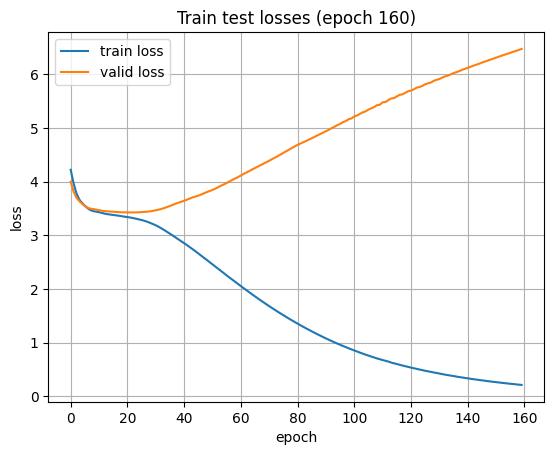

Scoring...:   0%|          | 0/10 [00:00<?, ?it/s]

AssertionError: 6.468098831176758. Model doesn't train well

In [15]:
def overfit_one_batch_check():
    # Для проверки работоспособности кода обучения удоно использовать тест модели на overfit 
    # Для этого запускается обучение на одном батче данных. 
    # Если код написан правильно, то модель обязана выучить выучить все примеры из этого батча наизусть. 
    fe = FeatureExtractor()
    train_dataset = FeatsPhoneDataset('timit/data/TEST/DR1/FAKS0', feature_extractor=fe, phone2id=PHONE2ID)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, collate_fn=train_dataset.collate_pad)
    test_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, collate_fn=train_dataset.collate_pad)

    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                   out_dim=max(PHONE2ID.values()) + 1,  
                                   dim=256, 
                                   num_layers=6, 
                                   ff_dim=512, 
                                   dropout=0.0, 
                                   nhead=8), 
                      fe=fe, 
                      phone2id=PHONE2ID, device='cuda')
   
    # only one batch. The model must learn it by heart
    losses, val_losses = trainer.fit(train_dataloader, 160, valid_dataloader=test_dataloader, plot_losses=False)

    trainer.plot_losses(losses, val_losses)

    val_loss = np.mean(trainer.score(test_dataloader))
    
    assert val_loss < 0.5, f"{val_loss}. Model doesn't train well" 
    print(f"Test 3.a passed")
overfit_one_batch_check()

In [ ]:

def experiment():
    # Запуск полноценного обучения модели
    # TODO: Тюнинг гиперпараметров
    fe = FeatureExtractor()
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataset = FeatsPhoneDataset('timit/data/TRAIN/', feature_extractor=fe, phone2id=PHONE2ID)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=40, 
                                               num_workers=0, collate_fn=train_dataset.collate_pad, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)


    trainer = Trainer(model=AModel(feats_dim=fe.feats_dim, 
                                 out_dim=max(PHONE2ID.values())+1, 
                                 dim=128, 
                                 num_layers=7, 
                                 ff_dim=256, 
                                 dropout=0.0, 
                                 nhead=8),
                     fe=fe, 
                     phone2id=PHONE2ID, device='cuda')

    trainer.fit(train_dataloader, epochs=40, valid_dataloader=test_dataloader, plot_losses=True)
    return trainer.to('cpu')
results = experiment()

Found 1680 utterances in timit/data/TEST/.  1680 wavs,  1680 texts,  1680 word alinments,  1680 phone alignments
Found 4620 utterances in timit/data/TRAIN/.  4620 wavs,  4620 texts,  4620 word alinments,  4620 phone alignments
AModel(
  (input_ff): Linear(in_features=40, out_features=128, bias=True)
  (positional_encoding): Embedding(780, 128)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-6): 7 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

/tmp/ipykernel_34161/1192423107.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  feats = [torch.tensor(item['feats']) for item in batch]
/tmp/ipykernel_34161/1192423107.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.cat([torch.tensor(item['targets']) for item in batch])


OutOfMemoryError: CUDA out of memory. Tried to allocate 206.00 MiB. GPU 0 has a total capacty of 3.81 GiB of which 107.94 MiB is free. Process 4783 has 187.48 MiB memory in use. Including non-PyTorch memory, this process has 3.49 GiB memory in use. Of the allocated memory 3.37 GiB is allocated by PyTorch, and 39.15 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
torch.save(results, 'baseline.trainer')

# Основное задание (12 баллов)
Надо улучшить бейзлайн так, чтобы значение loss на валидации было менее 1.9 

**Дополнительное задание** (4 балла): Улучшите loss до 1.4 

In [ ]:
def test_trained_model(trainer):
    test_dataset = FeatsPhoneDataset('timit/data/TEST/', feature_extractor=trainer.fe, phone2id=trainer.phone2id)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, 
                                               num_workers=0, collate_fn=test_dataset.collate_pad, shuffle=False)
    loss = np.mean(trainer.score(test_dataloader))
    print(f"Test loss is {loss}")
    assert loss < 1.9, "Main task failed"
    print(f"Main task is done! (12 points)")
    if loss <= 1.4:
        print(f"Additional task is done! (+4 points)")
test_trained_model(results.to('cuda'))